# Building a REACT Tool Using LangGraph with memory

In [25]:
#Importing required library 
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode


#Loading the API Key and building base model 
from dotenv import load_dotenv
load_dotenv(override=True)
import os 
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
##Selecting the model 
model = "deepseek-r1-distill-llama-70b"
## Building the base model using Gorq
from langchain_groq import ChatGroq
llm=ChatGroq(model_name=model)


#Defining the tool to "Search" weather information 
##Name of the tool is "search" with docstring explaining the functionality 
@tool 
def search(query: str): 
    """ This is a custom tool to search weather information"""
    
    if "delhi" in query.lower():
        return "Temperature is 45 Degree and Sunny"
    
    return "Temperature is 25 Degree and Sunny"

## Storing the tool name into a tool variable
tools = [search]

##Converting the tool onto ToolNode 
tool_node = ToolNode(tools)

#Converting the base model into LLM with Tool Calling ability => Tool Binding
## Binding LLM with tools 
llm_with_tools = llm.bind_tools(tools)

##Building the base LLM Call function (also act as a Supervisor node for Reasoning)
def call_model(state: MessagesState):
    question = state["messages"] #Collecting user input 
    response = llm_with_tools.invoke(question)
    return {"messages": [response]}

#Define Router Function : It will determine what route the control from call_model to next steps 

def router_function(state: MessagesState):
    message = state["messages"]
    last_message = message[-1] #Taking last message 
    if last_message.tool_calls:
        return "tools"
    return END

#Building a React Workflow 
workflow3 = StateGraph(MessagesState)
##Adding nodes 
workflow3.add_node("llmwithtools", call_model)
workflow3.add_node("mytools", tool_node) #Node that contain the tools 
##Add Edges 
workflow3.add_edge(START, "llmwithtools")
workflow3.add_conditional_edges(
    "llmwithtools",
    router_function, 
    {
        "tools" : "mytools",
        END : END 
    }
)
##Feedback loop 
workflow3.add_edge("mytools", "llmwithtools")

#Compiling the workflow by adding memory  
## Creating object of Memory Saver 
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver() 
#Creating app 
app4 = workflow3.compile(checkpointer=memory)

#Configuring memory thread by providing Thread ID to be 1 
config = { "configurable" : {"thread_id" : "1"}}

#Invoking the workflow / app by passing the configuration 
events = app4.stream(
    {"messages" : ["Where is kerala ?"]}, 
    config=config, 
    stream_mode="values"
)

#Display the output 
for event in events: 
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Where is kerala ?
================================== Ai Message ==================================
Tool Calls:
  search (tvb9mc9kw)
 Call ID: tvb9mc9kw
  Args:
    query: Where is Kerala
================================= Tool Message =================================
Name: search

Temperature is 25 Degree and Sunny
================================== Ai Message ==================================

Kerala is a state in southern India, located on the southwestern coast along the Arabian Sea. It is known for its beautiful beaches, backwaters, tea plantations, and vibrant culture. The capital of Kerala is Thiruvananthapuram. The current weather in Kerala is 25 degrees Celsius with sunny conditions.


In [26]:
memory.get(config)


{'v': 2,
 'ts': '2025-07-23T02:15:20.646407+00:00',
 'id': '1f0676ae-2208-6e4e-8003-4d6e1d5f78ac',
 'channel_versions': {'__start__': '00000000000000000000000000000002.0.19881466531781533',
  'messages': '00000000000000000000000000000005.0.8765032533939111',
  'start:llmwithtools': '00000000000000000000000000000003.0.5830181775984273',
  'llmwithtools': '00000000000000000000000000000005.0.86078852429216',
  'branch:llmwithtools:router_function:mytools': '00000000000000000000000000000004.0.6308822732257794',
  'mytools': '00000000000000000000000000000005.0.19094456776445212'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000001.0.7532866299053583'},
  'llmwithtools': {'start:llmwithtools': '00000000000000000000000000000002.0.5576256808979654',
   'mytools': '00000000000000000000000000000004.0.6956240810761871'},
  'mytools': {'branch:llmwithtools:router_function:mytools': '00000000000000000000000000000003.0.1882994866013783'}},
 'pending_se

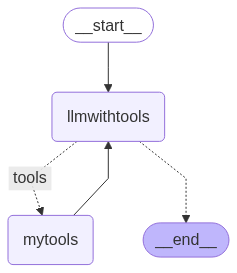

In [15]:
from IPython.display import Image, display
display(Image(app4.get_graph().draw_mermaid_png())) 
